In [136]:
import os
import numpy as np
import iris
import iris.coord_categorisation
import iris.analysis.cartography
import cf_units
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as mpatches
import iris.quickplot as qplt
import seaborn as sns
import pandas as pd
import datetime
from iris.coord_categorisation import add_year, \
    add_month_number, add_day_of_month, add_day_of_year
import warnings
warnings.simplefilter("ignore")

In [153]:
def prepare_calendar(cube, tcoord_name='time'):
    # Setting up the dates on data
    for coord_name, coord_func in [('year', iris.coord_categorisation.add_year),
                                   ('month_number', iris.coord_categorisation.add_month_number),
                                   ('day_of_month', iris.coord_categorisation.add_day_of_month),
                                   ('day_of_year', iris.coord_categorisation.add_day_of_year),
                                   ('hour', iris.coord_categorisation.add_hour)]:
        if not cube.coords(coord_name):
            coord_func(cube, tcoord_name, name=coord_name)
    return cube
    # Constrain the cubes to May-September period for all years
def may_september_constraint(cube):
    return cube.extract(iris.Constraint(month_number=lambda month_number: 5 <= month_number <= 9))

def create_dates_df(cube):
    cube = prepare_calendar(cube, tcoord_name='forecast_time')
    cube_dates_dt = [datetime.datetime(y, m, d) for y, m, d in zip(cube.coord('year').points,
                                                                   cube.coord('month_number').points,
                                                                   cube.coord('day_of_month').points)]
    # Extract year, month, and day from each datetime object
    data = {
    'Year': [dt.year for dt in cube_dates_dt],
    'Month': [dt.month for dt in cube_dates_dt],
    'Day': [dt.day for dt in cube_dates_dt]
    }
    
    # Create a Pandas DataFrame
    df = pd.DataFrame(data)
    
    # Create a new 'date' column with datetime objects
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    return df
def read_bsiso_eofs():
    eof_data_dir = '../data'
    eof_data_file = os.path.join(eof_data_dir, 'BSISO.EOFstruc.data')
    eofs = pd.read_csv(eof_data_file, delim_whitespace=True)
    
    nlat = eofs['YY'].max()
    nlon = eofs['XX'].max()
    lons = np.linspace(40, 160, nlon)
    lats = np.linspace(-10.,40., nlat)
    
    comb_eof1 = np.concatenate((eofs.OLR1, eofs.U8501), axis=0)
    comb_eof2 = np.concatenate((eofs.OLR2, eofs.U8502), axis=0)
    
    return comb_eof1, comb_eof2
def calculate_mjo_phase(rmm1, rmm2):
    # Calculate the phase angle
    phase_angle = np.arctan2(rmm2, rmm1)
    
    # Convert negative angles to positive
    phase_angle = np.where(phase_angle < 0, phase_angle + 2 * np.pi, phase_angle)

    # Define the phase categories based on the phase angle
    phase = np.zeros(len(phase_angle), dtype=int)
    phase = np.where((phase_angle >= 0) & (phase_angle < np.pi / 4), 5,
                     np.where((phase_angle >= np.pi / 4) & (phase_angle < np.pi / 2), 6,
                              np.where((phase_angle >= np.pi / 2) & (phase_angle < 3 * np.pi / 4), 7,
                                       np.where((phase_angle >= 3 * np.pi / 4) & (phase_angle < np.pi), 8,
                                                np.where((phase_angle >= np.pi) & (phase_angle < 5 * np.pi / 4), 1,
                                                         np.where((phase_angle >= 5 * np.pi / 4) & (phase_angle < 3 * np.pi / 2), 2,
                                                                  np.where((phase_angle >= 3 * np.pi / 2) & (phase_angle < 7 * np.pi / 4), 3, 4)))))))

    return phase

In [154]:
# compute aread averaged standard deviation of OLR and 
# Define the region and the time period
longitude_range = (40, 160)
latitude_range = (-10, 40)
time_range = ('2000-05-01', '2020-09-30')
grid_spacing = 2.5

In [155]:
# Load the OLR and U850 data
olr_file = '/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/NOAA_OLR_tropics_24h_mean_2000_2020.nc'
u850_file = '/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/obs_U850.pp.nc'
olr_cube = iris.load_cube(olr_file)
u850_cube = iris.load_cube(u850_file)

olr_cube = olr_cube.intersection(longitude=longitude_range, latitude=latitude_range)
u850_cube = u850_cube.intersection(longitude=longitude_range, latitude=latitude_range)

In [156]:
olr_cube.coord('longitude').attributes = {}
u850_cube.coord('longitude').attributes = {}
u850_cube = u850_cube.regrid(olr_cube, iris.analysis.Linear())
u850_cube.shape, olr_cube.shape

((7305, 17, 49), (7671, 17, 49))

In [157]:
olr_cube = prepare_calendar(olr_cube)
u850_cube = prepare_calendar(u850_cube)

In [158]:
olr_cube = may_september_constraint(olr_cube)
u850_cube = may_september_constraint(u850_cube)

In [159]:
olr_sd = olr_cube.collapsed('time', iris.analysis.STD_DEV)
u850_sd = u850_cube.collapsed('time', iris.analysis.STD_DEV)

In [160]:
olr_sd_x = olr_sd.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).data
u850_sd_x = u850_sd.collapsed(['latitude', 'longitude'], iris.analysis.MEAN).data

In [161]:
float(olr_sd_x), float(u850_sd_x)

(35.367244720458984, 3.917308896882387)

In [165]:
# These numbers are from https://iprc.soest.hawaii.edu/users/jylee/bsiso/data/PROJ.BSISOEOF.f90
pc1_sd = 12.
pc2_sd = 10.
pc3_sd = 8.8
pc4_sd = 8.4

In [166]:
df = pd.DataFrame({'index':[0], 'olr_sd_x': [float(olr_sd_x)], 'u850_sd_x': [float(u850_sd_x)], 
                   'pc1_sd': [pc1_sd], 'pc2_sd': [pc2_sd], 'pc3_sd': [pc3_sd], 'pc4_sd': [pc4_sd]})
df

,index,olr_sd_x,u850_sd_x,pc1_sd,pc2_sd,pc3_sd,pc4_sd
0,0,35.367245,3.917309,12.0,10.0,8.8,8.4


In [167]:
# Save to CSV
df.to_csv('../data/BSISO_coefficients.csv', index=False)  # S

In [168]:
df = pd.read_csv('../data/BSISO_coefficients.csv')
df                 

,index,olr_sd_x,u850_sd_x,pc1_sd,pc2_sd,pc3_sd,pc4_sd
0,0,35.367245,3.917309,12.0,10.0,8.8,8.4


In [197]:
date = datetime.datetime(2024, 5, 15)
mem = '002'
nanalysis2write=40
model='glosea'

date_label = date.strftime("%Y%m%d")
# Read data
olr_cube = iris.load_cube(f'/scratch/hadpx/SEA_monitoring/processed_SEA_data/{model}/MJO/olr/olr_120dm_40sn_nrt_{date_label}_{mem}.nc')
u850_cube = iris.load_cube(f'/scratch/hadpx/SEA_monitoring/processed_SEA_data/{model}/MJO/u850/u850_120dm_40sn_nrt_{date_label}_{mem}.nc')

reg_constraints = iris.Constraint(latitude=lambda cell: -10 <= cell <= 40) & iris.Constraint(longitude=lambda cell: 40. <= cell <= 160.)

olr_cube = olr_cube.extract(constraint=reg_constraints)
u850_cube = u850_cube.extract(constraint=reg_constraints)

# Normalization by area averaged temporal standard deviation over the Asian region
olr_cube /= df['olr_sd_x']
u850_cube /= df['u850_sd_x']

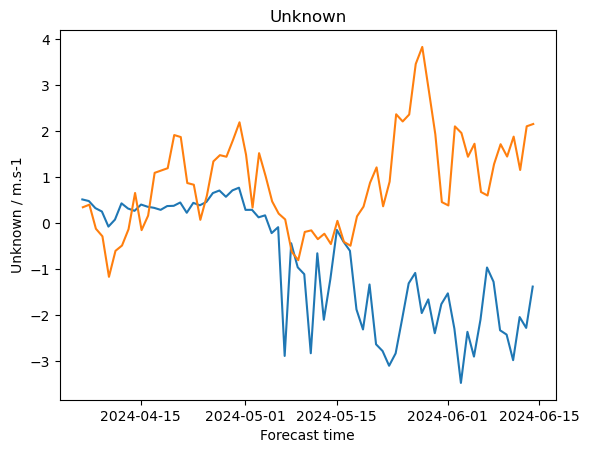

In [198]:
qplt.plot(olr_cube[:, 10, 25])
qplt.plot(u850_cube[:, 10, 25])

In [199]:
pcs = create_dates_df(olr_cube)

70 21 49


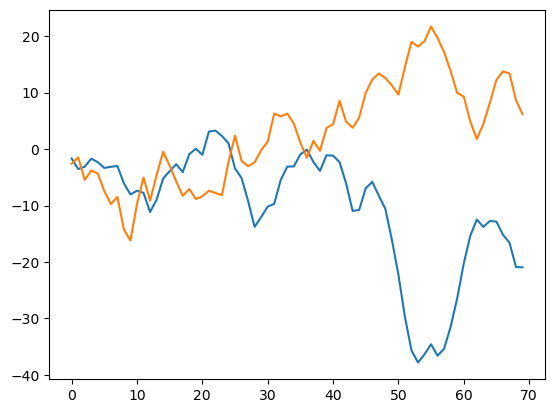

In [200]:
ntime, nlat_cube, nlon_cube = olr_cube.shape
print(ntime, nlat_cube, nlon_cube)
#if (nlat_cube == nlat) & (nlon_cube==nlon):
#    print('Cube dims match')
olr_resh = np.reshape(olr_cube.data, (ntime, -1))
u850_resh = np.reshape(u850_cube.data, (ntime, -1))

# Combining the data along the lat-lon dimensions
comb_fcast_data = np.concatenate((olr_resh, u850_resh), axis=1)
comb_fcast_data.shape

# Read Predefined EOF structures
comb_eof1, comb_eof2 = read_bsiso_eofs()

# Assuming comb_eof1 is a 1D array of shape (2058,)
# and comb_fcast_data is a 2D array of shape (261, 2058)
pcs['PC1'] = np.dot(comb_fcast_data, comb_eof1)
pcs['PC2'] = np.dot(comb_fcast_data, comb_eof2)
plt.plot(pcs.PC1)
plt.plot(pcs.PC2)

In [201]:
# Normalise PC1 and PC2 by 12, 10
pcs['PC1'] = pcs['PC1']/df['pc1_sd'].values
pcs['PC2'] = pcs['PC2']/df['pc2_sd'].values

pcs['8_phases'] = calculate_mjo_phase(pcs['PC1'].values, pcs['PC2'].values)
pcs['amp'] = np.sqrt(pcs['PC1'].values**2+pcs['PC2'].values**2)
pcs['mem'] = [mem for i in range(len(pcs))]

(-4.0, 4.0)

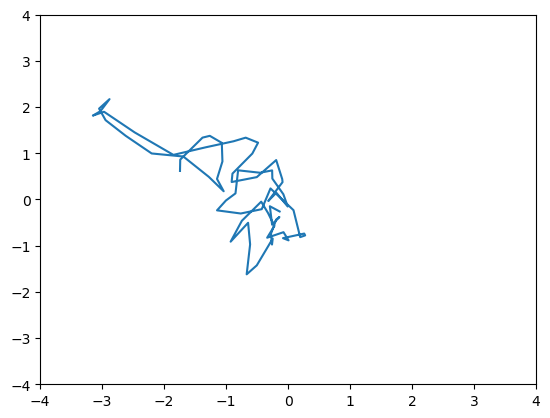

In [202]:
plt.plot(pcs.PC1, pcs.PC2)
plt.xlim([-4,4])
plt.ylim([-4,4])

In [190]:
pcs

,Year,Month,Day,date,PC1,PC2,8_phases,amp,mem
0,2024,4,6,2024-04-06,-0.138533,-0.259654,2,0.294298,000
1,2024,4,7,2024-04-07,-0.295820,-0.146650,1,0.330176,000
2,2024,4,8,2024-04-08,-0.260118,-0.545796,2,0.604611,000
3,2024,4,9,2024-04-09,-0.142119,-0.379965,2,0.405674,000
4,2024,4,10,2024-04-10,-0.193734,-0.433561,2,0.474877,000
...,...,...,...,...,...,...,...,...,...
65,2024,6,10,2024-06-10,-2.570161,0.511764,8,2.620616,000
66,2024,6,11,2024-06-11,-2.009357,0.886031,8,2.196034,000
67,2024,6,12,2024-06-12,-1.817034,1.027767,8,2.087563,000
68,2024,6,13,2024-06-13,-1.921783,1.107248,8,2.217938,000
